In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl, seaborn.apionly as sns
import pcmdpy as ppy
ppy.gpu_utils.initialize_gpu(n=0)
%matplotlib inline

GPU acceleration enabled
using given n: 0
Starting SourceModule Code
Past the SourceModule code
CUDAC Available


In [2]:
filters_to_use = ppy.instrument.m51_filters[:2]
f = [f_() for f_ in filters_to_use]
iso_model = ppy.isochrones.Isochrone_Model(f)

In [3]:
driv = ppy.driver.Driver(iso_model, gpu=True)

In [4]:
def set_exposures(factor=1.):
    exposures = np.array([1360, 1360, 2720]) * factor
    f = [f_(exposure=e) for f_, e in zip(filters_to_use, exposures)]
    iso_model.filters = f
    driv.filters = f

In [5]:
set_exposures(1.)

Baseline models:

[Fe/H] = 0

0.1 mags extinction

Constant SFR

Npix = [1e2, 1e3, 1e4]

distance = 8.58 Mpc (M51)

In [6]:
dmod = 25. + 5.*np.log10(8.58)

In [7]:
gal2 = ppy.galaxy.CustomGalaxy(ppy.metalmodels.SingleFeH(), ppy.dustmodels.SingleDust(), ppy.agemodels.ConstantSFR(), 
                              ppy.distancemodels.FixedDistance(dmod), np.array([0., -1., 2]))

gal3 = ppy.galaxy.CustomGalaxy(ppy.metalmodels.SingleFeH(), ppy.dustmodels.SingleDust(), ppy.agemodels.ConstantSFR(), 
                              ppy.distancemodels.FixedDistance(dmod), np.array([0., -1., 3.]))

gal4 = ppy.galaxy.CustomGalaxy(ppy.metalmodels.SingleFeH(), ppy.dustmodels.SingleDust(), ppy.agemodels.ConstantSFR(), 
                              ppy.distancemodels.FixedDistance(dmod), np.array([0., -1., 4.]))

In [8]:
sky_noise = np.array([82., 41.])

In [9]:
sky_mags = np.array([f_.counts_to_mag(np.array([s]))[0] for f_, s in zip(f, sky_noise)])

In [10]:
sky_mags

array([28.57761264, 29.53368763])

In [11]:
def get_pcmds(exp_factor=1., sky_factor=1., shot_noise=True, N_im=1024):
    set_exposures(factor=exp_factor)
    if sky_factor <= 0.:
        sky = None
    else:
        sky = sky_noise * sky_factor * exp_factor
    pcmd2, _ = driv.simulate(gal2, N_im, shot_noise=shot_noise, sky_noise=sky, downsample=5, fixed_seed=True)
    pcmd2, _ = driv.simulate(gal2, N_im, shot_noise=shot_noise, sky_noise=sky, downsample=5, fixed_seed=True)
    pcmd3, _ = driv.simulate(gal3, N_im, shot_noise=shot_noise, sky_noise=sky, downsample=5, fixed_seed=True)
    pcmd4, _ = driv.simulate(gal4, N_im, shot_noise=shot_noise, sky_noise=sky, downsample=5, fixed_seed=True)
    set_exposures(factor=1.)
    return pcmd2, pcmd3, pcmd4

In [12]:
%%time
pcmds2, pcmds3, pcmds4 = {}, {}, {}
pcmds2['base'], pcmds3['base'], pcmds4['base'] = get_pcmds(exp_factor=1., sky_factor=0., shot_noise=False)

CPU times: user 4.19 s, sys: 1.01 s, total: 5.21 s
Wall time: 5.82 s


In [13]:
%%time
key = 'w/shot'
pcmds2[key], pcmds3[key], pcmds4[key] = get_pcmds(exp_factor=1., sky_factor=0., shot_noise=True)

CPU times: user 4.81 s, sys: 911 ms, total: 5.72 s
Wall time: 5.99 s


In [14]:
%%time
key = 'w/sky'
pcmds2[key], pcmds3[key], pcmds4[key] = get_pcmds(exp_factor=1., sky_factor=1., shot_noise=False)

CPU times: user 4.95 s, sys: 915 ms, total: 5.86 s
Wall time: 6.13 s


In [15]:
%%time
key = 'shot+sky'
pcmds2[key], pcmds3[key], pcmds4[key] = get_pcmds(exp_factor=1., sky_factor=1., shot_noise=True)

CPU times: user 5.96 s, sys: 955 ms, total: 6.91 s
Wall time: 7.31 s


In [16]:
%%time
key = '10xsky'
pcmds2[key], pcmds3[key], pcmds4[key] = get_pcmds(exp_factor=1., sky_factor=10., shot_noise=True)

CPU times: user 5.7 s, sys: 922 ms, total: 6.62 s
Wall time: 6.9 s


In [17]:
%%time
key = '0.1xsky'
pcmds2[key], pcmds3[key], pcmds4[key] = get_pcmds(exp_factor=1., sky_factor=0.1, shot_noise=True)

CPU times: user 5.66 s, sys: 910 ms, total: 6.57 s
Wall time: 6.86 s


In [18]:
%%time
key = '10xexp'
pcmds2[key], pcmds3[key], pcmds4[key] = get_pcmds(exp_factor=10., sky_factor=1., shot_noise=True)

CPU times: user 5.65 s, sys: 934 ms, total: 6.59 s
Wall time: 6.88 s


In [19]:
%%time
key = '0.1xexp'
pcmds2[key], pcmds3[key], pcmds4[key] = get_pcmds(exp_factor=.1, sky_factor=1., shot_noise=True)

CPU times: user 5.69 s, sys: 989 ms, total: 6.68 s
Wall time: 7.09 s


In [20]:
pcmds2.keys()

dict_keys(['base', 'w/shot', 'w/sky', 'shot+sky', '10xsky', '0.1xsky', '10xexp', '0.1xexp'])

In [21]:
bins = [np.arange(-1, 3, 0.05), np.arange(20, 32, 0.05)]

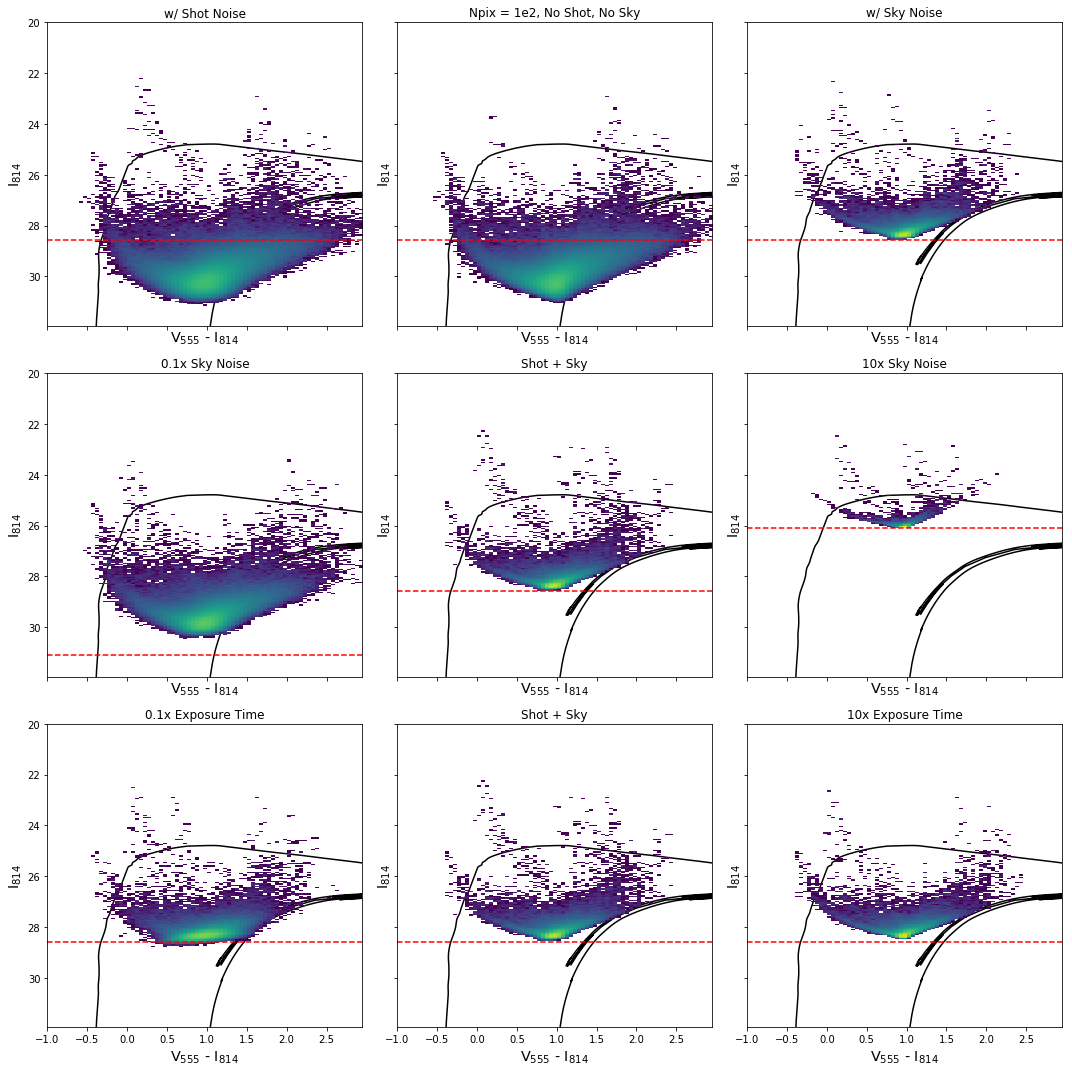

In [35]:
# Npix = 1e2
d = pcmds2
fig, axes = plt.subplots(ncols=3, nrows=3, sharex=True, sharey=True, figsize=(15, 15))
n = mpl.colors.LogNorm(vmax=4e5)
ppy.plotting.plot_pcmd(d['w/shot'], ax=axes[0,0], bins=bins, norm=n); axes[0,0].set_title('w/ Shot Noise')
ppy.plotting.plot_pcmd(d['base'], ax=axes[0,1], bins=bins, norm=n); axes[0,1].set_title('Npix = 1e2, No Shot, No Sky')
ppy.plotting.plot_pcmd(d['w/sky'], ax=axes[0,2], bins=bins, norm=n); axes[0,2].set_title('w/ Sky Noise')
ppy.plotting.plot_pcmd(d['0.1xsky'], ax=axes[1,0], bins=bins, norm=n); axes[1,0].set_title('0.1x Sky Noise')
ppy.plotting.plot_pcmd(d['shot+sky'], ax=axes[1,1], bins=bins, norm=n); axes[1,1].set_title('Shot + Sky')
ppy.plotting.plot_pcmd(d['10xsky'], ax=axes[1,2], bins=bins, norm=n); axes[1,2].set_title('10x Sky Noise')
ppy.plotting.plot_pcmd(d['0.1xexp'], ax=axes[2,0], bins=bins, norm=n); axes[2,0].set_title('0.1x Exposure Time')
ppy.plotting.plot_pcmd(d['shot+sky'], ax=axes[2,1], bins=bins, norm=n); axes[2,1].set_title('Shot + Sky')
ppy.plotting.plot_pcmd(d['10xexp'], ax=axes[2,2], bins=bins, norm=n); axes[2,2].set_title('10x Exposure Time')
for i, a in enumerate(axes.flatten()):
    ppy.plotting.plot_isochrone(iso_model, dmod=dmod, axes=a, zorder=-1)
    sky_level = sky_mags[0]
    if i == 3:
        sky_level += 2.5
    elif i == 5:
        sky_level -= 2.5
    a.axhline(y=sky_level, ls='--', color='r')
plt.tight_layout()
plt.savefig('figures/shot_sky_1e2.pdf')

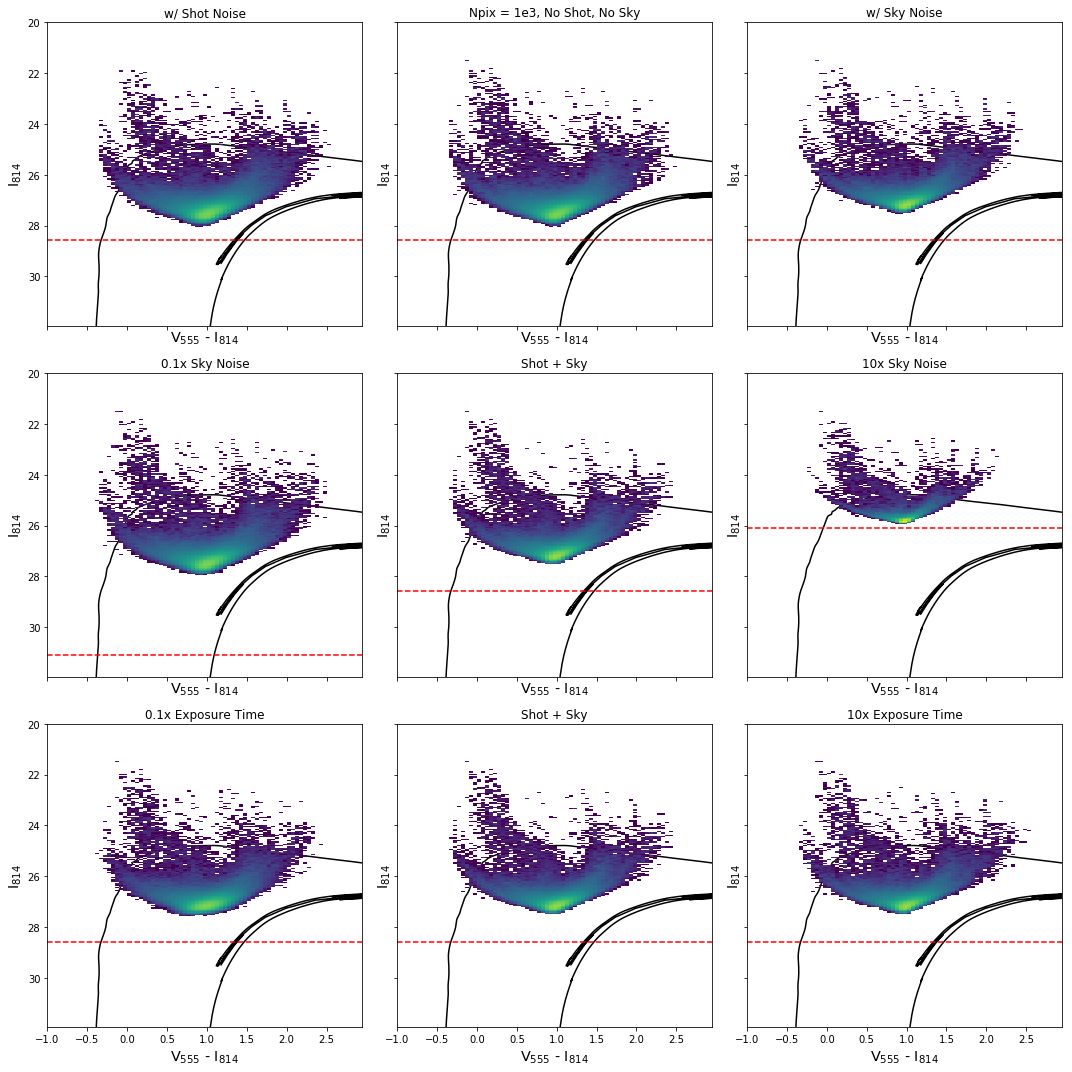

In [41]:
# Npix = 1e3
d = pcmds3
fig, axes = plt.subplots(ncols=3, nrows=3, sharex=True, sharey=True, figsize=(15, 15))
n = mpl.colors.LogNorm(vmax=4e5)
ppy.plotting.plot_pcmd(d['w/shot'], ax=axes[0,0], bins=bins, norm=n); axes[0,0].set_title('w/ Shot Noise')
ppy.plotting.plot_pcmd(d['base'], ax=axes[0,1], bins=bins, norm=n); axes[0,1].set_title('Npix = 1e3, No Shot, No Sky')
ppy.plotting.plot_pcmd(d['w/sky'], ax=axes[0,2], bins=bins, norm=n); axes[0,2].set_title('w/ Sky Noise')
ppy.plotting.plot_pcmd(d['0.1xsky'], ax=axes[1,0], bins=bins, norm=n); axes[1,0].set_title('0.1x Sky Noise')
ppy.plotting.plot_pcmd(d['shot+sky'], ax=axes[1,1], bins=bins, norm=n); axes[1,1].set_title('Shot + Sky')
ppy.plotting.plot_pcmd(d['10xsky'], ax=axes[1,2], bins=bins, norm=n); axes[1,2].set_title('10x Sky Noise')
ppy.plotting.plot_pcmd(d['0.1xexp'], ax=axes[2,0], bins=bins, norm=n); axes[2,0].set_title('0.1x Exposure Time')
ppy.plotting.plot_pcmd(d['shot+sky'], ax=axes[2,1], bins=bins, norm=n); axes[2,1].set_title('Shot + Sky')
ppy.plotting.plot_pcmd(d['10xexp'], ax=axes[2,2], bins=bins, norm=n); axes[2,2].set_title('10x Exposure Time')
for i, a in enumerate(axes.flatten()):
    ppy.plotting.plot_isochrone(iso_model, dmod=dmod, axes=a, zorder=-1)
    sky_level = sky_mags[0]
    if i == 3:
        sky_level += 2.5
    elif i == 5:
        sky_level -= 2.5
    a.axhline(y=sky_level, ls='--', color='r')
plt.tight_layout()
plt.savefig('figures/shot_sky_1e3.pdf')

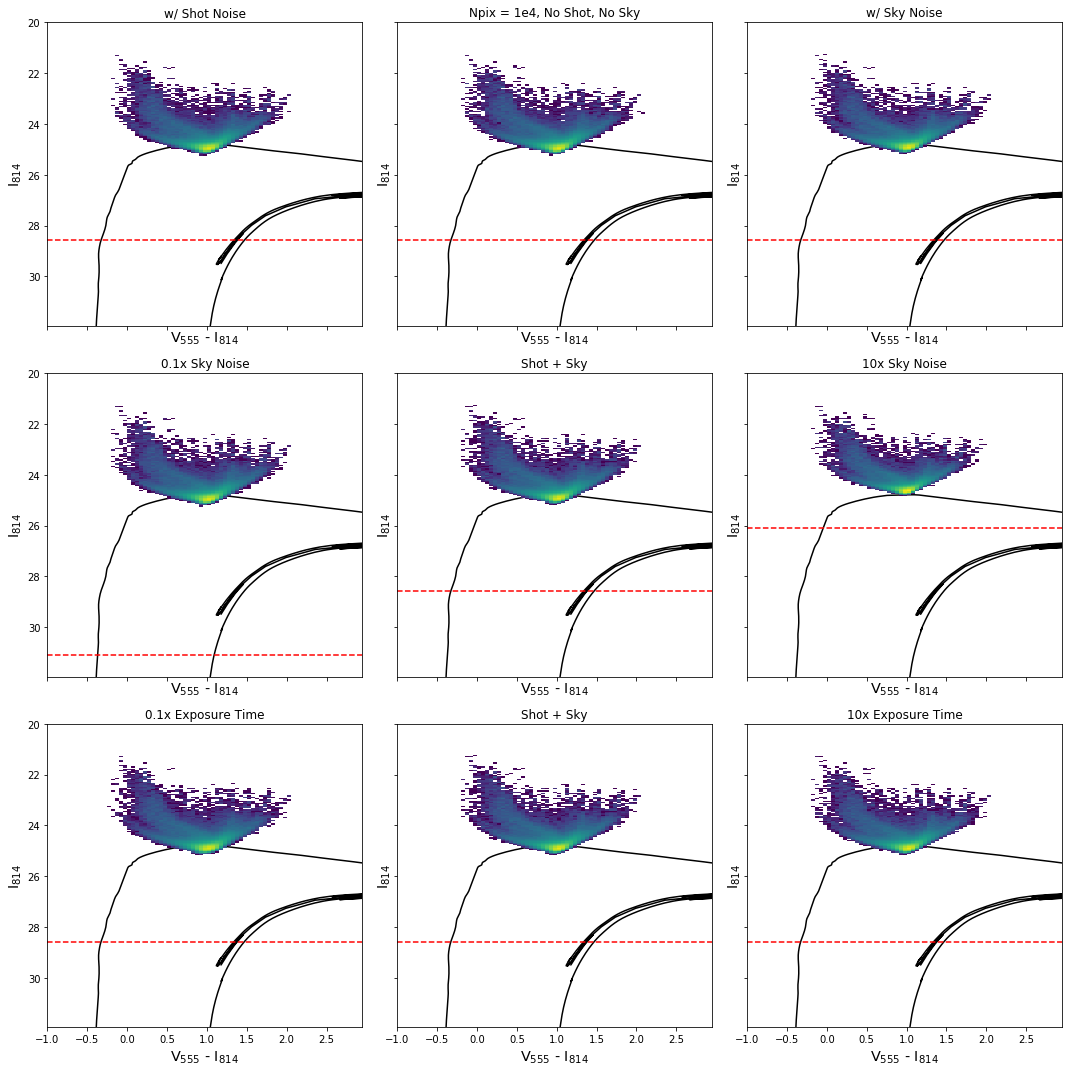

In [40]:
# Npix = 1e4
d = pcmds4
fig, axes = plt.subplots(ncols=3, nrows=3, sharex=True, sharey=True, figsize=(15, 15))
n = mpl.colors.LogNorm(vmax=2e5)
ppy.plotting.plot_pcmd(d['w/shot'], ax=axes[0,0], bins=bins, norm=n); axes[0,0].set_title('w/ Shot Noise')
ppy.plotting.plot_pcmd(d['base'], ax=axes[0,1], bins=bins, norm=n); axes[0,1].set_title('Npix = 1e4, No Shot, No Sky')
ppy.plotting.plot_pcmd(d['w/sky'], ax=axes[0,2], bins=bins, norm=n); axes[0,2].set_title('w/ Sky Noise')
ppy.plotting.plot_pcmd(d['0.1xsky'], ax=axes[1,0], bins=bins, norm=n); axes[1,0].set_title('0.1x Sky Noise')
ppy.plotting.plot_pcmd(d['shot+sky'], ax=axes[1,1], bins=bins, norm=n); axes[1,1].set_title('Shot + Sky')
ppy.plotting.plot_pcmd(d['10xsky'], ax=axes[1,2], bins=bins, norm=n); axes[1,2].set_title('10x Sky Noise')
ppy.plotting.plot_pcmd(d['0.1xexp'], ax=axes[2,0], bins=bins, norm=n); axes[2,0].set_title('0.1x Exposure Time')
ppy.plotting.plot_pcmd(d['shot+sky'], ax=axes[2,1], bins=bins, norm=n); axes[2,1].set_title('Shot + Sky')
ppy.plotting.plot_pcmd(d['10xexp'], ax=axes[2,2], bins=bins, norm=n); axes[2,2].set_title('10x Exposure Time')
for i, a in enumerate(axes.flatten()):
    ppy.plotting.plot_isochrone(iso_model, dmod=dmod, axes=a, zorder=-1)
    sky_level = sky_mags[0]
    if i == 3:
        sky_level += 2.5
    elif i == 5:
        sky_level -= 2.5
    a.axhline(y=sky_level, ls='--', color='r')
plt.tight_layout()
plt.savefig('figures/shot_sky_1e4.pdf')